<a target="_blank" href="https://colab.research.google.com/github/ginal001/ML-2024-2025/blob/main/Lab4/Homework04.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Homework Assignment: Analyzing and Plotting Bias in Penalized Regression**

-------------------------------

In this assignment, you will explore how **Ridge** and **Lasso** regression introduce **bias** into a model to reduce **variance**, and how the choice of the regularization parameter $\lambda$ affects this trade-off. The goal is to visualize and analyze the **bias-variance trade-off** and understand the conditions under which penalization helps or hinders model performance.

## **The Question**

**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**

- Generate a synthetic dataset based on a **known** linear relationship:
  
  $$
  y = \beta_0 + \beta_1 x + \ldots + \epsilon
  $$

  where $$\epsilon \sim \mathcal{N}(0, \sigma^2),$$

  use a **high-dimensional** setting (e.g., 50 predictors) with only a few non-zero true coefficients to emphasize the effects of regularization. I stress, the $\beta_i$ coefficients should be known for this experiment and they should be mostly 0, with only a few non-zero parameters.

- Investigate how increasing $\lambda$ influences the model’s **bias**, **variance**, and **Mean Squared Error (MSE)**.
- Plot **Bias²**, **Variance**, and **MSE** on a single graph for both Ridge and Lasso models.
- Explain MSE decomposition into bias and variance. Read more on the MSE decomposition if you need to.

**Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.**




**Expected Outcome:**
 - As $\lambda$ increases:
   - **Bias** increases (the model becomes too simple).
   - **Variance** decreases (the model becomes more stable).
   - **MSE** forms a **U-shape**, revealing the optimal trade-off.

- Analyze how **Ridge** and **Lasso** differ in terms of their bias-variance trade-offs.
- Discuss situations where one method may outperform the other, considering factors like **feature sparsity** and **multicollinearity**.


## **Colab Notebook Requirements**
- Your **Colab notebook** should:
  - Simulate the synthetic dataset and apply Ridge and Lasso regression.
  - Plot **Bias²**, **Variance**, and **MSE** against $\lambda$ for both models.
  - Include a section answering the questions.
  - Be well-documented with comments and explanations for each step.


## **Publish on GitHub**
- Upload your Colab notebook to your **GitHub repository** for this course.
- In your repository’s **README**, include a **link** to the notebook.
- In the notebook include **“Open in Colab”** badge so the notebook can be launched directly from GitHub.

## Solution ##

Firstly, we are going to create synthetic dataset. We are going to create model with 50 coefficients and only 5 are going to be nonzero. Then, we create random X_test and its corresponding y_test.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

# Defining dimensionality of data
n_samples =  200
n_features = 50 

# Defining model where we have 0.1 of nonzero betas 
true_coef = np.zeros(n_features)
non_zero_indices = np.random.randint(1, n_features + 1, size = int(0.1*n_features)).tolist() + [0]  
beta_values = np.random.uniform(1, 5, int(0.1*n_features) + 1)
true_coef[non_zero_indices] = beta_values

#Definining variance of error (normal, mean = 0, variance = sigma^2)
sigma = 2

# Definining test set
X_test = np.random.uniform(-1, 1, (n_samples, n_features - 1))
X_test = np.hstack((np.ones((n_samples, 1)), X_test)) # adding bias
true_f_test = X_test@true_coef

errors = sigma*np.random.randn(n_samples)
y_test = true_f_test + errors

To estimate error, we are going to repeat experiment 100 times.

In [29]:
#Defining number of simulations
n_simulations = 100

Let's create some helper functions. 

In [30]:
n_training = 4*n_samples

def true_function(X):
    return X @ true_coef

def generate_train_data():
    X_train = np.random.uniform(-1, 1, (n_training, n_features - 1))
    X_train = np.hstack((np.ones((n_training, 1)), X_train)) # adding bias

    errors = sigma*np.random.randn(n_training)
    y_train = true_function(X_train) + errors
    return X_train, y_train

And the most important chunk: creating models and repeating experiment. In function *simulations* we are creating synthetic X_training and its corresponding y_training with some noise. We are going to fit *Ridge* and *Lasso* model and then test them on X_test and y_test. Finally we are averaging over number of simulations to estimate *bias2* and *variance*. From those estimates, we know also *MSE* -- we know variance of error so we can use this formula (bias-variance tradeoff):
$$
\mathrm{MSE} 
= \bigl(f(x) - \mathbb{E}[\hat{f}(x)]\bigr)^2 
  + \mathbb{E}\bigl[\bigl(\mathbb{E}[\hat{f}(x)] - \hat{f}(x)\bigr)^2\bigr]
  + \sigma^2
= \mathrm{Bias}(\hat{f}(x))^2 
  + \mathrm{Var}[\hat{f}(x)] 
  + \sigma^2.
$$
where
$$
f(x) = \beta_0 + \beta_1  x_1 + \ldots + \beta_{50}  x_{50}
$$
As a output of our function, we will get pandas dataframe which is self-explanatory.

In [31]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def simulations(alpha):
    lasso_preds = np.zeros((n_samples, n_simulations))
    ridge_preds = np.zeros((n_samples, n_simulations))
    for i in range(n_simulations):
        X_train, y_train = generate_train_data()
        lasso = Lasso(alpha = alpha*n_training)  #multiplying alpha by n_samples to have standard version of lasso (not this one implemented by scikit)
        ridge = Ridge(alpha = alpha)
    
        lasso.fit(X_train, y_train)
        ridge.fit(X_train, y_train)

        lasso_preds[:, i] = lasso.predict(X_test)
        ridge_preds[:, i] = ridge.predict(X_test)

    avg_lasso_preds = np.mean(lasso_preds, axis = 1)
    bias2_lasso = np.mean((true_f_test - avg_lasso_preds) ** 2)
    variance_lasso = np.mean(np.var(lasso_preds, axis = 1))
    #mse_lasso = bias2_lasso + variance_lasso + (sigma** 2)
    mse_lasso = np.mean((lasso_preds - y_test.reshape(-1, 1)) ** 2)

    avg_ridge_preds = np.mean(ridge_preds, axis = 1)
    bias2_ridge = np.mean((true_f_test - avg_ridge_preds) **2)
    variance_ridge = np.mean(np.var(ridge_preds, axis = 1))
    #mse_ridge = bias2_ridge + variance_ridge + (sigma** 2)
    mse_ridge = np.mean((ridge_preds - y_test.reshape(-1, 1)) ** 2)

    
    data = {
    'alpha': alpha,
    'Lasso Bias²': bias2_lasso,
    'Lasso Variance': variance_lasso,
    'Lasso MSE': mse_lasso,
    'Ridge Bias²': bias2_ridge,
    'Ridge Variance': variance_ridge,
    'Ridge MSE': mse_ridge
    }

    df = pd.DataFrame([data])
    return(df)

Let's try different alphas and save the results.

In [32]:
alphas = np.logspace(-5, -3, 50)  # from 0.00001 to 10000

results = [simulations(alpha) for alpha in alphas]

df_results = pd.concat(results, ignore_index=True)

df_results.head()

,alpha,Lasso Bias²,Lasso Variance,Lasso MSE,Ridge Bias²,Ridge Variance,Ridge MSE
0,0.000010,0.003752,0.193696,4.804510,0.002542,0.261597,4.877496
1,0.000011,0.004510,0.181409,4.763008,0.004376,0.252249,4.837847
2,0.000012,0.003087,0.178686,4.758303,0.001922,0.256249,4.841249
3,0.000013,0.003885,0.171012,4.758504,0.002191,0.254285,4.844589
4,0.000015,0.003678,0.163816,4.774682,0.001885,0.256902,4.882532


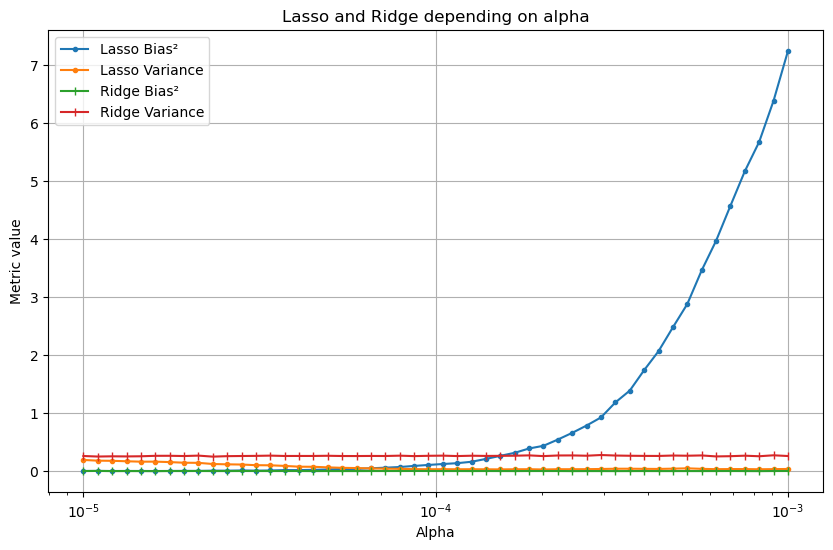

In [33]:
plt.figure(figsize=(10, 6))

# Lasso plot
plt.plot(df_results['alpha'], df_results['Lasso Bias²'], label='Lasso Bias²', marker='.')
plt.plot(df_results['alpha'], df_results['Lasso Variance'], label='Lasso Variance', marker='.')
#plt.plot(df_results['alpha'], df_results['Lasso MSE'], label='Lasso MSE', marker='.')

# Ridge plot
plt.plot(df_results['alpha'], df_results['Ridge Bias²'], label='Ridge Bias²', marker='|')
plt.plot(df_results['alpha'], df_results['Ridge Variance'], label='Ridge Variance', marker='|')
#plt.plot(df_results['alpha'], df_results['Ridge MSE'], label='Ridge MSE', marker='o')

plt.xscale('log') 
plt.xlabel('Alpha')
plt.ylabel('Metric value')
plt.title('Lasso and Ridge depending on alpha')
plt.legend()
plt.grid(True)
plt.show()

The plots exhibit a U-shape, which clearly demonstrates the bias-variance tradeoff. It's important to note that the alpha parameter plays a crucial role: higher alpha values increase bias but reduce variance and model complexity. We need to select an alpha that effectively minimizes both, capturing the essence of the bias-variance tradeoff. What's more, plots for lasso and ridge seems to be the same shape but they are not - we are using log scale on x-axis. From that we can conclude that lasso is more aggresive and it is reducing coefficients faster - which is known from labs. On the other hand, ridge is smoother and easier to select proper alpha. 

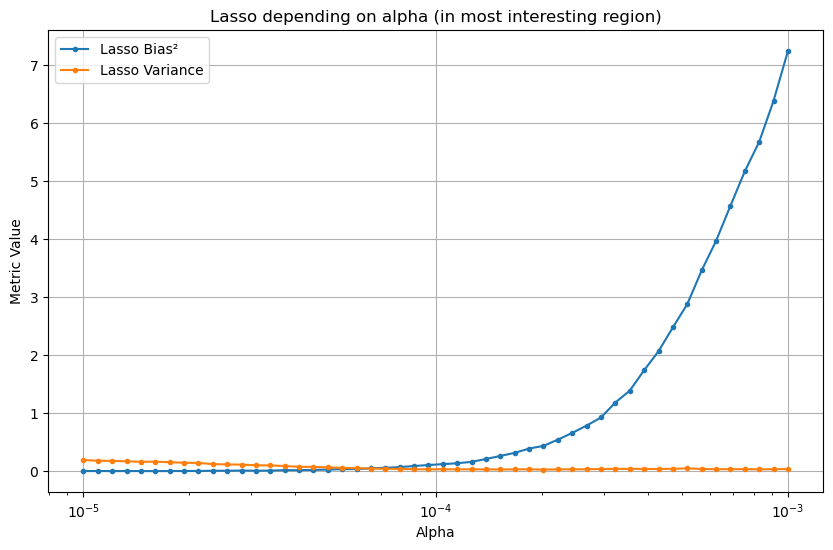

In [34]:
df_filtered_lasso = df_results[(df_results['alpha'] >= 10**(-5)) & (df_results['alpha'] <= 10**(-3))]

plt.figure(figsize=(10, 6))

plt.plot(df_filtered_lasso['alpha'], df_filtered_lasso['Lasso Bias²'], label='Lasso Bias²', marker='.')
plt.plot(df_filtered_lasso['alpha'], df_filtered_lasso['Lasso Variance'], label='Lasso Variance', marker='.')
#plt.plot(df_filtered_lasso['alpha'], df_filtered_lasso['Lasso MSE'], label='Lasso MSE', marker='.')

plt.xscale('log') 
plt.xlabel('Alpha')
plt.ylabel('Metric Value')
plt.title('Lasso depending on alpha (in most interesting region)')
plt.legend()
plt.grid(True)
plt.show()

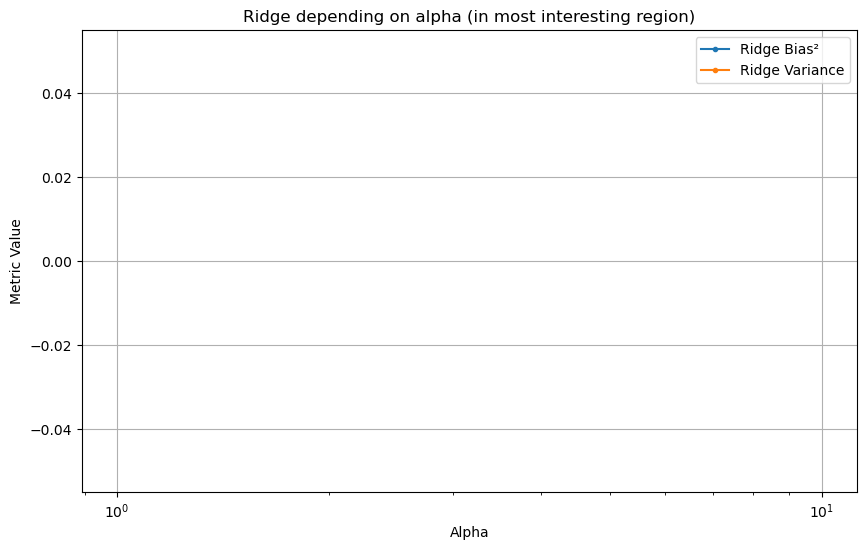

In [35]:
df_filtered_ridge = df_results[(df_results['alpha'] >= 10) & (df_results['alpha'] <= 10000)]

plt.figure(figsize=(10, 6))

plt.plot(df_filtered_ridge['alpha'], df_filtered_ridge['Ridge Bias²'], label='Ridge Bias²', marker='.')
plt.plot(df_filtered_ridge['alpha'], df_filtered_ridge['Ridge Variance'], label='Ridge Variance', marker='.')
#plt.plot(df_filtered_ridge['alpha'], df_filtered_ridge['Ridge MSE'], label='Ridge MSE', marker='.')

plt.xscale('log') 
plt.xlabel('Alpha')
plt.ylabel('Metric Value')
plt.title('Ridge depending on alpha (in most interesting region)')
plt.legend()
plt.grid(True)
plt.show()

In the code, we have skipped plot of MSE to improve readability of our plots (and to see clearly U-shape). At the end, we are plotting MSE, variance and bias2 to realise the instruction from the assignment. The error is large because of irreducible error (variance of $\epsilon$).

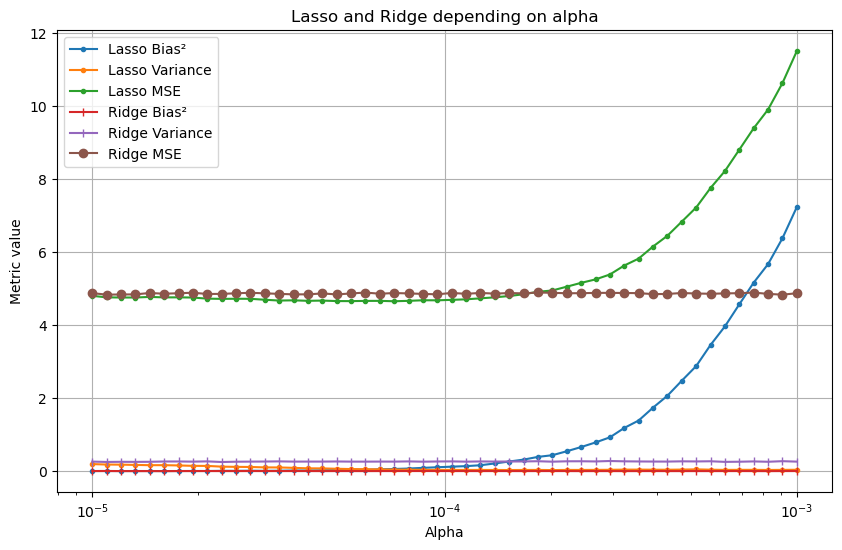

In [36]:
plt.figure(figsize=(10, 6))

# Lasso plot
plt.plot(df_results['alpha'], df_results['Lasso Bias²'], label='Lasso Bias²', marker='.')
plt.plot(df_results['alpha'], df_results['Lasso Variance'], label='Lasso Variance', marker='.')
plt.plot(df_results['alpha'], df_results['Lasso MSE'], label='Lasso MSE', marker='.')

# Ridge plot
plt.plot(df_results['alpha'], df_results['Ridge Bias²'], label='Ridge Bias²', marker='|')
plt.plot(df_results['alpha'], df_results['Ridge Variance'], label='Ridge Variance', marker='|')
plt.plot(df_results['alpha'], df_results['Ridge MSE'], label='Ridge MSE', marker='o')

plt.xscale('log') 
plt.xlabel('Alpha')
plt.ylabel('Metric value')
plt.title('Lasso and Ridge depending on alpha')
plt.legend()
plt.grid(True)
plt.show()

# Answers
Regularization creates an optimal trade-off point where the mean squared error (MSE) is minimized. As we increase the regularization strength, the model’s bias increases while its variance decreases. Since both bias and variance contribute to the overall MSE, there is a sweet spot where the reduction in variance perfectly offsets the increase in bias, thereby minimizing the MSE. In essence, regularization helps us achieve the best balance between bias and variance, leading to a more generalizable model.

---------
In some cases, one method may outperform other. Let's consider:
- **Feature sparsity**: in this situation, we expect that most of coefficients are going to be zero. As we remember from labs, LASSO method is more aggresive and leads coefficients of model to 0. It's desirable and may outperform Ridge where the coefficients are often close to zero but not zero. Also, it provides more interpretable model.
- **Multicollinearity**: in the situation when we expect that most of coefficients are important and correlated with others, Ridge is probably better option. It is going to decrease coefficients but they will not exact 0. It provides more stable model where most of coefficients have small but some contribution to output.